GPU disponible: True
Dispositivos GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Shapes:
Train images: (60000, 32, 32, 3)
Test images: (10000, 32, 32, 3)
Train labels: (60000, 10)
Test labels: (10000, 10)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipython-input-2198211896.py:124: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

ENTRENAMIENTO DE MODELOS CON TRANSFER LEARNING

MODELO: VGG16_Transfer

Resumen de arquitectura:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Parámetros totales: 14,848,586
Parámetros entrenables: 133,898
Parámetros NO entrenables: 14,714,688
Porcentaje congelado: 99.1%

Entrenando VGG16_Transfer...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.2820 - loss: 2.0669 - val_accuracy: 0.7530 - val_loss: 0.9347
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6259 - loss: 1.1243 - val_accuracy: 0.8158 - val_loss: 0.6180
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7063 - loss: 0.8731 - val_accuracy: 0.8545 - val_loss: 0.4955
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7421 - loss: 0.7668 - val_accuracy: 0.8728 - val_loss: 0.4314
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7692 - loss: 0.6979 - val_accuracy: 0.8860 - val_loss: 0.3839
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7803 - loss: 0.6542 - val_accuracy: 0.8977 - val_loss: 0.3530
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accu

Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,850 (91.99 MB)

 Trainable params: 527,626 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)


Parámetros totales: 24,115,850
Parámetros entrenables: 527,626
Parámetros NO entrenables: 23,588,224
Porcentaje congelado: 97.8%

Entrenando ResNet50_Transfer...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.2069 - loss: 2.5896 - val_accuracy: 0.6672 - val_loss: 1.1994
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4452 - loss: 1.6186 - val_accuracy: 0.7487 - val_loss: 0.9093
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5373 - loss: 1.3570 - val_accuracy: 0.7905 - val_loss: 0.7632
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5840 - loss: 1.2261 - val_accuracy: 0.8262 - val_loss: 0.6761
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6158 - loss: 1.1429 - val_accuracy: 0.8372 - val_loss: 0.6264
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6327 - loss: 1.0861 - val_accuracy: 0.8488 - val_loss: 0.5942
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accurac

Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Parámetros totales: 2,423,242
Parámetros entrenables: 165,258
Parámetros NO entrenables: 2,257,984
Porcentaje congelado: 93.2%

Entrenando MobileNetV2_Transfer...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.2175 - loss: 2.2064 - val_accuracy: 0.4835 - val_loss: 1.8809
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4095 - loss: 1.8645 - val_accuracy: 0.5488 - val_loss: 1.5768
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4388 - loss: 1.6701 - val_accuracy: 0.5907 - val_loss: 1.4235
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4592 - loss: 1.5814 - val_accuracy: 0.6180 - val_loss: 1.3360
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4676 - loss: 1.5333 - val_accuracy: 0.6325 - val_loss: 1.2774
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4816 - loss: 1.4959 - val_accuracy: 0.6447 - val_loss: 1.2366
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.

Model: "CNN_Simple_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,226 (8.37 MB)

 Trainable params: 2,193,226 (8.37 MB)

 Non-trainable params: 0 (0.00 B)


Parámetros totales: 2,193,226
Parámetros entrenables: 2,193,226
Parámetros NO entrenables: 0
Porcentaje congelado: 0.0%

Entrenando CNN_Baseline...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8717 - loss: 0.3955 - val_accuracy: 0.9873 - val_loss: 0.0416
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9822 - loss: 0.0587 - val_accuracy: 0.9908 - val_loss: 0.0339
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9883 - loss: 0.0387 - val_accuracy: 0.9915 - val_loss: 0.0327
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9907 - loss: 0.0309 - val_accuracy: 0.9915 - val_loss: 0.0338
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9923 - loss: 0.0228 - val_accuracy: 0.9918 - val_loss: 0.0323
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9929 - loss: 0.0222 - val_accuracy: 0.9922 - val_loss: 0.0323
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9948 - loss: 0.

Model: "VGG16_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.4841 - loss: 1.5492 - val_accuracy: 0.9690 - val_loss: 0.1149
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9422 - loss: 0.2048 - val_accuracy: 0.9827 - val_loss: 0.0544
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9683 - loss: 0.1109 - val_accuracy: 0.9862 - val_loss: 0.0422
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9759 - loss: 0.0861 - val_accuracy: 0.9878 - val_loss: 0.0356
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9803 - loss: 0.0693 - val_accuracy: 0.9910 - val_loss: 0.0314

⏱️  Tiempo de fine-tuning: 1.25 minutos

✅ VGG16_FineTuned
   Test Accuracy: 98.80%
   Test Loss: 0.0373

COMPARACIÓN FINAL: TRANSFER LEARNING vs CNN DESDE CERO

Tabla comparativa:
--------------------------------------------------------------------------------
Modelo                    Accuracy        Loss            Parámetros          
-------------

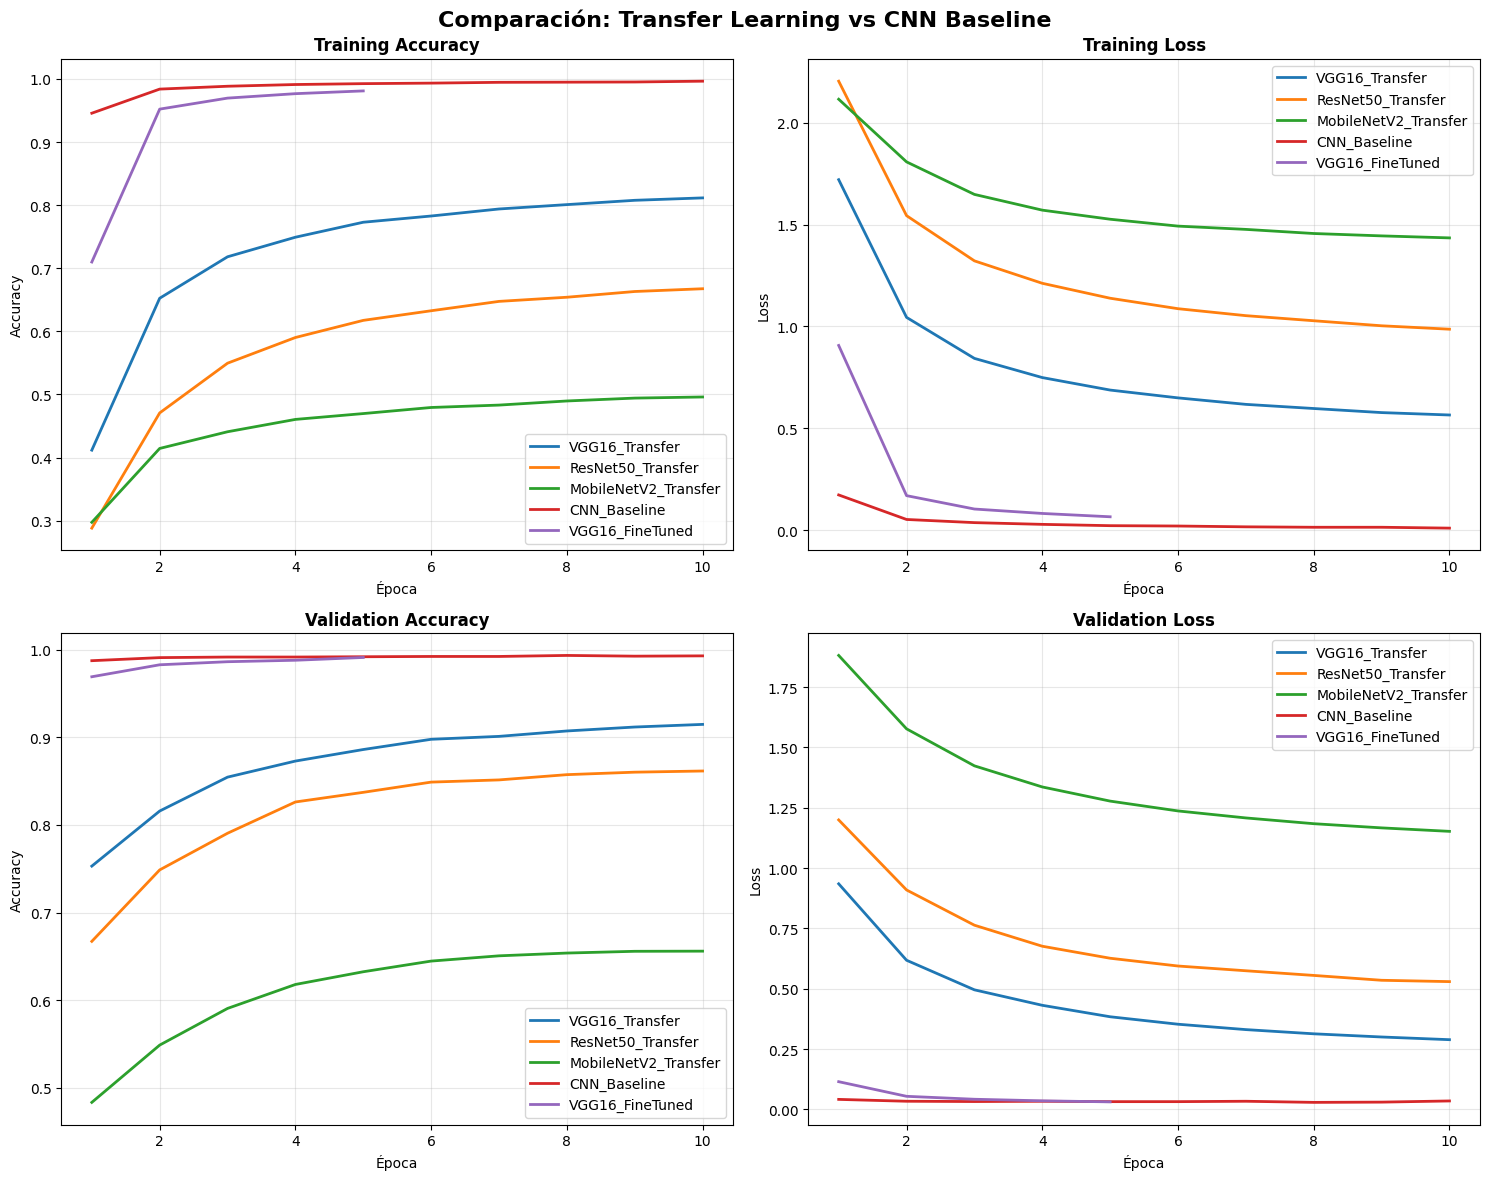


¡Gráficas guardadas en 'transfer_learning_comparison.png'!

ANÁLISIS: Visualización de Feature Maps (VGG16)

Visualizando feature maps de: ['block1_conv1', 'block1_conv2', 'block2_conv1']


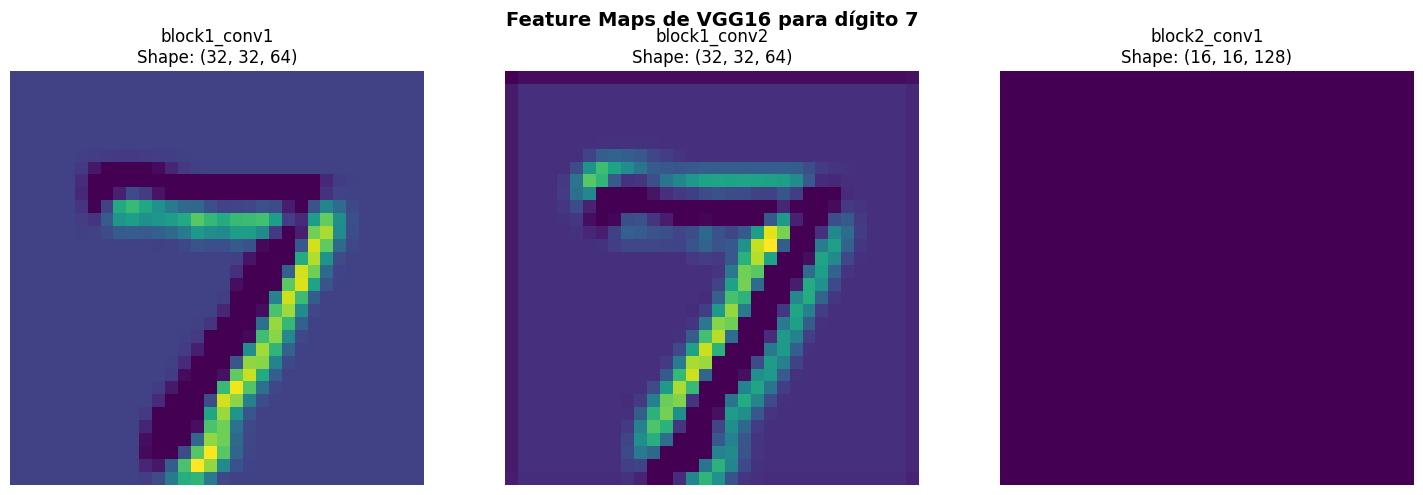

¡Feature maps guardados en 'feature_maps_vgg16.png'!

EJEMPLOS DE PREDICCIONES (Modelo VGG16)

Comparación de predicciones vs etiquetas reales:
--------------------------------------------------
Imagen 1:
  Predicción: 7
  Real: 7
  Confianza: 99.53%
  Correcto: ✓

Imagen 2:
  Predicción: 2
  Real: 2
  Confianza: 92.26%
  Correcto: ✓

Imagen 3:
  Predicción: 1
  Real: 1
  Confianza: 99.93%
  Correcto: ✓

Imagen 4:
  Predicción: 0
  Real: 0
  Confianza: 94.05%
  Correcto: ✓

Imagen 5:
  Predicción: 4
  Real: 4
  Confianza: 97.50%
  Correcto: ✓



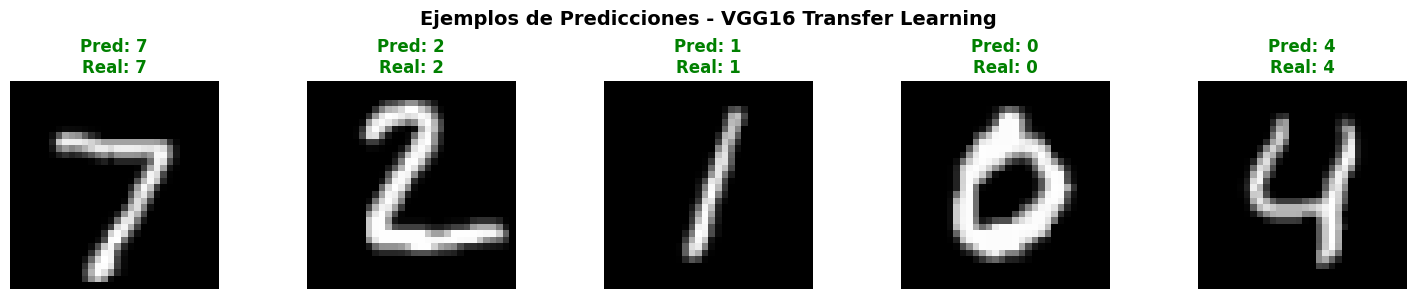

¡Predicciones guardadas en 'predictions_examples.png'!

PRÁCTICA 4 COMPLETADA

📊 CONCLUSIONES:
--------------------------------------------------------------------------------
✓ Transfer Learning permite reutilizar conocimiento de ImageNet
✓ Modelos pre-entrenados logran alta precisión con menos entrenamiento
✓ VGG16, ResNet50, MobileNet tienen diferentes trade-offs:
  - VGG16: Simple, muchos parámetros, alto rendimiento
  - ResNet50: Más profundo, bloques residuales, eficiente
  - MobileNetV2: Ligero, rápido, ideal para dispositivos móviles
✓ Fine-tuning puede mejorar resultados ajustando últimas capas
✓ Congelar capas reduce tiempo de entrenamiento drásticamente
--------------------------------------------------------------------------------


In [1]:
# ============================================================================================
# PRÁCTICA 4: TRANSFER LEARNING CON MODELOS PRE-ENTRENADOS PARA MNIST
# ============================================================================================

# ----------------------------------------------------------------------------
# IMPORTACIÓN DE LIBRERÍAS
# ----------------------------------------------------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
import matplotlib.pyplot as plt

# Configuración para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Verificar GPU
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Dispositivos GPU: {tf.config.list_physical_devices('GPU')}")

# ----------------------------------------------------------------------------
# CARGA Y PREPROCESAMIENTO DE DATOS
# ----------------------------------------------------------------------------

# Cargar MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalizar [0, 255] -> [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# IMPORTANTE: Los modelos pre-entrenados esperan imágenes RGB (3 canales)
# MNIST es escala de grises (1 canal), así que replicamos el canal 3 veces
train_images_rgb = np.stack([train_images] * 3, axis=-1)
test_images_rgb = np.stack([test_images] * 3, axis=-1)

# Redimensionar de 28x28 a 32x32 (mínimo para modelos pre-entrenados)
train_images_resized = tf.image.resize(train_images_rgb, [32, 32]).numpy()
test_images_resized = tf.image.resize(test_images_rgb, [32, 32]).numpy()

# Convertir etiquetas a one-hot
train_labels_categorical = to_categorical(train_labels, 10)
test_labels_categorical = to_categorical(test_labels, 10)

print(f"\nShapes:")
print(f"Train images: {train_images_resized.shape}")
print(f"Test images: {test_images_resized.shape}")
print(f"Train labels: {train_labels_categorical.shape}")
print(f"Test labels: {test_labels_categorical.shape}")

# ----------------------------------------------------------------------------
# MODELO 1: VGG16 CON TRANSFER LEARNING
# ----------------------------------------------------------------------------

def create_transfer_vgg16():
    """
    Transfer Learning usando VGG16 pre-entrenado en ImageNet.
    VGG16: 16 capas (13 convolucionales + 3 densas)
    """
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

    # Congelar el modelo base
    base_model.trainable = False

    # Construir modelo completo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ], name='VGG16_Transfer')

    return model

# ----------------------------------------------------------------------------
# MODELO 2: ResNet50 CON TRANSFER LEARNING
# ----------------------------------------------------------------------------

def create_transfer_resnet50():
    """
    Transfer Learning usando ResNet50.
    ResNet50: 50 capas con bloques residuales
    """
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ], name='ResNet50_Transfer')

    return model

# ----------------------------------------------------------------------------
# MODELO 3: MobileNetV2 CON TRANSFER LEARNING
# ----------------------------------------------------------------------------

def create_transfer_mobilenet():
    """
    Transfer Learning usando MobileNetV2.
    MobileNet: Optimizado para dispositivos móviles
    """
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ], name='MobileNetV2_Transfer')

    return model

# ----------------------------------------------------------------------------
# MODELO 4: CNN SIMPLE (BASELINE PARA COMPARAR)
# ----------------------------------------------------------------------------

def create_simple_cnn():
    """
    CNN simple entrenada desde cero para comparación.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(32, 32, 3), padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ], name='CNN_Simple_Baseline')

    return model

# ----------------------------------------------------------------------------
# ENTRENAMIENTO DE MODELOS
# ----------------------------------------------------------------------------

# Diccionario con todos los modelos
models_dict = {
    'VGG16_Transfer': create_transfer_vgg16(),
    'ResNet50_Transfer': create_transfer_resnet50(),
    'MobileNetV2_Transfer': create_transfer_mobilenet(),
    'CNN_Baseline': create_simple_cnn()
}

histories = {}

# Configuración
EPOCHS = 10
BATCH_SIZE = 128

print("\n" + "="*80)
print("ENTRENAMIENTO DE MODELOS CON TRANSFER LEARNING")
print("="*80)

import time

for name, model in models_dict.items():
    print(f"\n{'='*80}")
    print(f"MODELO: {name}")
    print(f"{'='*80}")

    # Compilar
    if 'Transfer' in name:
        optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    else:
        optimizer = 'adam'

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Resumen
    print("\nResumen de arquitectura:")
    model.summary()

    # Parámetros
    total_params = model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params

    print(f"\nParámetros totales: {total_params:,}")
    print(f"Parámetros entrenables: {trainable_params:,}")
    print(f"Parámetros NO entrenables: {non_trainable_params:,}")
    print(f"Porcentaje congelado: {(non_trainable_params/total_params)*100:.1f}%")

    # Medir tiempo
    start_time = time.time()

    # Entrenar
    print(f"\nEntrenando {name}...")
    history = model.fit(
        train_images_resized,
        train_labels_categorical,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1
    )

    elapsed_time = time.time() - start_time
    print(f"\n⏱️  Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")

    histories[name] = history.history

    # Evaluar
    test_loss, test_accuracy = model.evaluate(
        test_images_resized,
        test_labels_categorical,
        verbose=0
    )

    print(f"\n✅ {name}")
    print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"   Test Loss: {test_loss:.4f}")

# ----------------------------------------------------------------------------
# FINE-TUNING (OPCIONAL): DESCONGELAR ALGUNAS CAPAS
# ----------------------------------------------------------------------------

def create_finetuned_vgg16():
    """
    Fine-tuning: Descongelar últimas capas para ajuste fino.
    """
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

    # Congelar todas las capas primero
    base_model.trainable = True

    # Descongelar solo las últimas 4 capas
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ], name='VGG16_FineTuned')

    return model

# Crear y entrenar modelo con fine-tuning
print("\n" + "="*80)
print("FINE-TUNING: VGG16 con últimas capas descongeladas")
print("="*80)

model_finetuned = create_finetuned_vgg16()

# Compilar con learning rate MUY BAJO
model_finetuned.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_finetuned.summary()

start_time = time.time()

# Entrenar menos épocas
history_finetuned = model_finetuned.fit(
    train_images_resized,
    train_labels_categorical,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)

elapsed_time = time.time() - start_time
print(f"\n⏱️  Tiempo de fine-tuning: {elapsed_time/60:.2f} minutos")

test_loss_ft, test_accuracy_ft = model_finetuned.evaluate(
    test_images_resized,
    test_labels_categorical,
    verbose=0
)

print(f"\n✅ VGG16_FineTuned")
print(f"   Test Accuracy: {test_accuracy_ft*100:.2f}%")
print(f"   Test Loss: {test_loss_ft:.4f}")

histories['VGG16_FineTuned'] = history_finetuned.history

# ----------------------------------------------------------------------------
# COMPARACIÓN DE RESULTADOS
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("COMPARACIÓN FINAL: TRANSFER LEARNING vs CNN DESDE CERO")
print("="*80)

comparison_data = []

for name, model in models_dict.items():
    test_loss, test_accuracy = model.evaluate(
        test_images_resized,
        test_labels_categorical,
        verbose=0
    )

    total_params = model.count_params()

    comparison_data.append({
        'Modelo': name,
        'Test Accuracy': f"{test_accuracy*100:.2f}%",
        'Test Loss': f"{test_loss:.4f}",
        'Parámetros': f"{total_params:,}"
    })

# Añadir fine-tuned
comparison_data.append({
    'Modelo': 'VGG16_FineTuned',
    'Test Accuracy': f"{test_accuracy_ft*100:.2f}%",
    'Test Loss': f"{test_loss_ft:.4f}",
    'Parámetros': f"{model_finetuned.count_params():,}"
})

print("\nTabla comparativa:")
print("-" * 80)
print(f"{'Modelo':<25} {'Accuracy':<15} {'Loss':<15} {'Parámetros':<20}")
print("-" * 80)
for data in comparison_data:
    print(f"{data['Modelo']:<25} {data['Test Accuracy']:<15} {data['Test Loss']:<15} {data['Parámetros']:<20}")
print("-" * 80)

# ----------------------------------------------------------------------------
# VISUALIZACIÓN DE RESULTADOS
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación: Transfer Learning vs CNN Baseline',
             fontsize=16, fontweight='bold')

# Subplot 1: Training Accuracy
ax = axes[0, 0]
for name, history in histories.items():
    epochs_range = range(1, len(history['accuracy']) + 1)
    ax.plot(epochs_range, history['accuracy'], label=name, linewidth=2)
ax.set_title('Training Accuracy', fontsize=12, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Subplot 2: Training Loss
ax = axes[0, 1]
for name, history in histories.items():
    epochs_range = range(1, len(history['loss']) + 1)
    ax.plot(epochs_range, history['loss'], label=name, linewidth=2)
ax.set_title('Training Loss', fontsize=12, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Subplot 3: Validation Accuracy
ax = axes[1, 0]
for name, history in histories.items():
    epochs_range = range(1, len(history['val_accuracy']) + 1)
    ax.plot(epochs_range, history['val_accuracy'], label=name, linewidth=2)
ax.set_title('Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Subplot 4: Validation Loss
ax = axes[1, 1]
for name, history in histories.items():
    epochs_range = range(1, len(history['val_loss']) + 1)
    ax.plot(epochs_range, history['val_loss'], label=name, linewidth=2)
ax.set_title('Validation Loss', fontsize=12, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('transfer_learning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n¡Gráficas guardadas en 'transfer_learning_comparison.png'!")

# ----------------------------------------------------------------------------
# ANÁLISIS DE FEATURE MAPS
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("ANÁLISIS: Visualización de Feature Maps (VGG16)")
print("="*80)

# Tomar una imagen de ejemplo
example_image = test_images_resized[0:1]
example_label = test_labels[0]

# Extraer el modelo base VGG16 del modelo completo
vgg16_model = models_dict['VGG16_Transfer'].layers[0]  # CORREGIDO: extraer base_model

# Obtener nombres de primeras 3 capas convolucionales
conv_layer_names = [layer.name for layer in vgg16_model.layers
                    if 'conv' in layer.name][:3]

print(f"\nVisualizando feature maps de: {conv_layer_names}")

# Crear modelo para extraer features
layer_outputs = [vgg16_model.get_layer(name).output for name in conv_layer_names]
activation_model = models.Model(inputs=vgg16_model.input, outputs=layer_outputs)

# Obtener activaciones
activations = activation_model.predict(example_image, verbose=0)

# Visualizar
fig, axes = plt.subplots(1, len(activations), figsize=(15, 5))
fig.suptitle(f'Feature Maps de VGG16 para dígito {example_label}',
             fontsize=14, fontweight='bold')

for i, (activation, layer_name) in enumerate(zip(activations, conv_layer_names)):
    # Tomar primer filtro de la activación
    feature_map = activation[0, :, :, 0]

    ax = axes[i]
    ax.imshow(feature_map, cmap='viridis')
    ax.set_title(f'{layer_name}\nShape: {activation.shape[1:]}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('feature_maps_vgg16.png', dpi=300, bbox_inches='tight')
plt.show()

print("¡Feature maps guardados en 'feature_maps_vgg16.png'!")

# ----------------------------------------------------------------------------
# PREDICCIONES DE EJEMPLO
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("EJEMPLOS DE PREDICCIONES (Modelo VGG16)")
print("="*80)

# Usar VGG16 para predicciones
model_to_test = models_dict['VGG16_Transfer']

# Tomar 5 ejemplos
num_examples = 5
example_images = test_images_resized[:num_examples]
example_labels_real = test_labels[:num_examples]

# Predecir
predictions = model_to_test.predict(example_images, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

print("\nComparación de predicciones vs etiquetas reales:")
print("-" * 50)
for i in range(num_examples):
    print(f"Imagen {i+1}:")
    print(f"  Predicción: {predicted_labels[i]}")
    print(f"  Real: {example_labels_real[i]}")
    print(f"  Confianza: {predictions[i][predicted_labels[i]]*100:.2f}%")
    print(f"  Correcto: {'✓' if predicted_labels[i] == example_labels_real[i] else '✗'}")
    print()

# Visualizar predicciones
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
fig.suptitle('Ejemplos de Predicciones - VGG16 Transfer Learning',
             fontsize=14, fontweight='bold')

for i in range(num_examples):
    ax = axes[i]
    # Mostrar imagen original (primer canal)
    ax.imshow(example_images[i, :, :, 0], cmap='gray')
    ax.axis('off')

    # Color según correcto/incorrecto
    color = 'green' if predicted_labels[i] == example_labels_real[i] else 'red'
    title = f"Pred: {predicted_labels[i]}\nReal: {example_labels_real[i]}"
    ax.set_title(title, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('predictions_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("¡Predicciones guardadas en 'predictions_examples.png'!")

print("\n" + "="*80)
print("PRÁCTICA 4 COMPLETADA")
print("="*80)

print("\n📊 CONCLUSIONES:")
print("-" * 80)
print("✓ Transfer Learning permite reutilizar conocimiento de ImageNet")
print("✓ Modelos pre-entrenados logran alta precisión con menos entrenamiento")
print("✓ VGG16, ResNet50, MobileNet tienen diferentes trade-offs:")
print("  - VGG16: Simple, muchos parámetros, alto rendimiento")
print("  - ResNet50: Más profundo, bloques residuales, eficiente")
print("  - MobileNetV2: Ligero, rápido, ideal para dispositivos móviles")
print("✓ Fine-tuning puede mejorar resultados ajustando últimas capas")
print("✓ Congelar capas reduce tiempo de entrenamiento drásticamente")
print("-" * 80)
